In [1]:
import warnings, os, json, joblib
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
RANDOM_STATE = 42               
NB_VARIANT = "gaussian"        

os.makedirs("model", exist_ok=True)
os.makedirs("data", exist_ok=True)
print('Environment ready.')

Environment ready.


In [3]:

# UCI official ZIP -> read bank/bank-full.csv
import io, zipfile, requests


OUTER_ZIP_URL = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"  # outer zip that contains bank.zip and bank-additional.zip
TARGET_INNER_ZIP = "bank.zip"          
TARGET_CSV_SUFFIX = "bank-full.csv"  
LOAD_SEP  = ";"                   
TARGET    = "y"                
DROP_COLUMNS = ["duration"]    

# 1) Download the outer ZIP
resp = requests.get(OUTER_ZIP_URL, timeout=60)
resp.raise_for_status()

with zipfile.ZipFile(io.BytesIO(resp.content)) as outer_zf:
    # 2) Find bank.zip inside the outer archive
    members = outer_zf.namelist()
    inner_zip_member = None
    for m in members:
        if m.lower().endswith("/" + TARGET_INNER_ZIP) or m.lower() == TARGET_INNER_ZIP:
            inner_zip_member = m
            break

    if inner_zip_member is None:
        raise FileNotFoundError(f"Could not find {TARGET_INNER_ZIP!r} inside {OUTER_ZIP_URL}. Members:\n" + "\n".join(members))

    # 3) Read bank.zip into memory
    with outer_zf.open(inner_zip_member) as inner_zip_file:
        inner_zip_bytes = inner_zip_file.read()

# 4) Open bank.zip (inner) and locate bank-full.csv by suffix
with zipfile.ZipFile(io.BytesIO(inner_zip_bytes)) as inner_zf:
    inner_members = inner_zf.namelist()
    csv_member = None
    for m in inner_members:
        if m.lower().endswith("/" + TARGET_CSV_SUFFIX) or m.lower() == TARGET_CSV_SUFFIX:
            csv_member = m
            break

    if csv_member is None:
        raise FileNotFoundError(f"Could not find {TARGET_CSV_SUFFIX!r} in {TARGET_INNER_ZIP}. Members:\n" + "\n".join(inner_members))

    # 5) Read CSV (UCI uses semicolon separator)
    with inner_zf.open(csv_member) as f:
        df = pd.read_csv(f, sep=LOAD_SEP)

print(df.shape)
df.head()


(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:

print('Shape:', df.shape)
print('Columns:', list(df.columns))
display(df.head())
print('Dtypes:')
print(df.dtypes)
print('Missing values per column:')
print(df.isna().sum())
print('Target distribution (raw):')
print(df[TARGET].value_counts())

Shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Dtypes:
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object
Missing values per column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Target distribution (raw):
y
no     39922
yes     5289
Name: count, dtype: int64


In [5]:

# Map common yes/no -> 1/0
if df[TARGET].dtype == 'O':
    df[TARGET] = df[TARGET].str.strip().str.lower().map({'yes':1, 'no':0})


if df[TARGET].isna().any():
    bad = df.loc[df[TARGET].isna(), TARGET]
    raise ValueError(f"Unexpected target labels found; cannot map to 0/1. Offending values: {bad.unique()[:5]}")

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [6]:

# Drop optional columns (e.g., leakage)
for c in DROP_COLUMNS:
    if c in df.columns:
        df = df.drop(columns=[c])
print('Dropped columns:', DROP_COLUMNS)
print('Columns after dropping:', list(df.columns))

Dropped columns: ['duration']
Columns after dropping: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [7]:
# Remove rows with missing target
df = df.dropna(subset=[TARGET]).reset_index(drop=True)
print('Shape after dropping missing target:', df.shape)

Shape after dropping missing target: (45211, 16)


In [8]:
# Identify column types
cat_cols = [c for c in df.columns if df[c].dtype == 'O' and c != TARGET]
num_cols = [c for c in df.columns if (np.issubdtype(df[c].dtype, np.number)) and c != TARGET]
print('Categorical columns:', cat_cols)
print('Numeric columns:', num_cols)

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric columns: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']


In [9]:

# Split 80/20 (Train/Test)

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print('Train class distribution:', np.bincount(y_train))
print('Test class distribution:', np.bincount(y_test))

Train: (36168, 15) Test: (9043, 15)
Train class distribution: [31937  4231]
Test class distribution: [7985 1058]


In [10]:
# Create a small TEST CSV from your existing split (includes target `y`)
test_sample = pd.concat([X_test, y_test.rename("y")], axis=1).copy()

test_sample = (
    test_sample
    .groupby('y', group_keys=False)
    .apply(lambda g: g.sample(min(len(g), 100), random_state=42))  # 100 from each class → ~200
    .reset_index(drop=True)
)

# Save with the same separator as source (UCI bank-full.csv uses ';')
test_sample.to_csv("data/test_sample.csv", sep=";", index=False)
print("Saved → data/test_sample.csv")

Saved → data/test_sample.csv


In [11]:

# Preprocessors

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# For LR & KNN (scale numerics)
preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", num_imputer), ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imputer", cat_imputer),
                          ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0
)

# For tree-based & NB (no scaling)
preprocess_basic = ColumnTransformer(
    transformers=[
        ("num", num_imputer, num_cols),
        ("cat", Pipeline([("imputer", cat_imputer),
                          ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0
)


def get_feature_names_from_fitted_preprocessor(fitted_preproc):
    if hasattr(fitted_preproc, "get_feature_names_out"):
        return list(fitted_preproc.get_feature_names_out())
    names = []
    for name, trans, cols in fitted_preproc.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps") and "ohe" in trans.named_steps:
            ohe = trans.named_steps["ohe"]
            names.extend(list(ohe.get_feature_names_out(cols)))
        elif hasattr(trans, "get_feature_names_out"):
            names.extend(list(trans.get_feature_names_out(cols)))
        else:
            names.extend(list(cols))
    return names

print('Preprocessors ready.')


Preprocessors ready.


In [12]:

# Models
models = {}

# 1) Logistic Regression
models["logreg"] = Pipeline(steps=[
    ("prep", preprocess_scaled),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))
])

# 2) Decision Tree
models["tree"] = Pipeline(steps=[
    ("prep", preprocess_basic),
    ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE))
])

# 3) KNN
models["knn"] = Pipeline(steps=[
    ("prep", preprocess_scaled),    
    ("clf", KNeighborsClassifier(n_neighbors=5))
])

# 4) Naive Bayes
if NB_VARIANT.lower().startswith("multi"):
    nb_est = MultinomialNB()   # requires non-negative features (e.g., counts)
else:
    nb_est = GaussianNB()
models["nb"] = Pipeline(steps=[
    ("prep", preprocess_basic),
    ("clf", nb_est)
])

# 5) Random Forest
models["rf"] = Pipeline(steps=[
    ("prep", preprocess_basic),
    ("clf", RandomForestClassifier(        
            n_estimators=150,         
            max_depth=12,             
            min_samples_leaf=3,      
            max_features="sqrt",      
            bootstrap=True,
            max_samples=0.8,          
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            ccp_alpha=1e-4
    ))
])

# 6) XGBoost
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = float(neg) / float(pos) if pos > 0 else 1.0

models["xgb"] = Pipeline(steps=[
    ("prep", preprocess_basic),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=120,
        learning_rate=0.1,
        max_depth=4,
        min_child_weight=4,
        gamma=0.0,
        subsample=0.8,
        colsample_bytree=0.7,
        reg_alpha=0.0,
        reg_lambda=2.0,
        scale_pos_weight=scale_pos_weight,
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

In [13]:

# ===============================
# Train & Evaluate
# ===============================

def auc_safely(y_true, proba):
    if proba is None:
        return np.nan
    try:
        # If model outputs shape (n_samples, 2), use prob for class 1
        if isinstance(proba, np.ndarray) and proba.ndim == 2 and proba.shape[1] >= 2:
            return roc_auc_score(y_true, proba[:, 1])
        else:
            return roc_auc_score(y_true, proba)
    except Exception:
        return np.nan


results = []
trained = {}

for name, pipe in models.items():
    print(f"Training: {name}")
    pipe.fit(X_train, y_train)
    trained[name] = pipe

    # Predict on test
    y_pred = pipe.predict(X_test)

    # Probabilities (if available)
    y_proba = None
    if hasattr(pipe, "predict_proba"):
        try:
            y_proba = pipe.predict_proba(X_test)
        except Exception:
            y_proba = None  # fall back gracefully if a model raises

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(y_test, y_pred)
    auc  = auc_safely(y_test, y_proba)

    results.append({
        "model": name, "Accuracy": acc, "AUC": auc,
        "Precision": prec, "Recall": rec, "F1": f1, "MCC": mcc
    })

metrics_df = pd.DataFrame(results).set_index("model").sort_values("AUC", ascending=False)
display(metrics_df.style.format("{:.4f}"))

# Save metrics
metrics_path = "model/metrics_summary.csv"
metrics_df.to_csv(metrics_path, index=True)
print("Saved:", metrics_path)


Training: logreg
Training: tree
Training: knn
Training: nb
Training: rf
Training: xgb


,Accuracy,AUC,Precision,Recall,F1,MCC
model,,,,,,
xgb,0.8122,0.8017,0.6429,0.7379,0.6655,0.3687
rf,0.8293,0.7983,0.6507,0.7266,0.6736,0.3696
logreg,0.7548,0.7722,0.6028,0.6980,0.6104,0.2853
nb,0.8410,0.7558,0.6458,0.6841,0.6608,0.3277
knn,0.8874,0.7027,0.7275,0.5882,0.6150,0.2833
tree,0.8405,0.6071,0.6102,0.6071,0.6086,0.2174


Saved: model/metrics_summary.csv


In [14]:

# Save artifacts & feature columns
for name, pipe in trained.items():
    out_path = f"model/model_{name}.joblib"
    # Use compression: xz yields smaller files; zlib (int) is faster
    if name in ("rf", "knn", "xgb"):  # typically the big ones
        joblib.dump(pipe, out_path, compress=("xz", 3))
    else:
        joblib.dump(pipe, out_path, compress=3)
    print("Saved:", out_path)


# save feature columns from any trained pipeline (use the first)

first_model = next(iter(trained.values()))
fitted_preproc = first_model.named_steps["prep"]

feat_names = get_feature_names_from_fitted_preprocessor(fitted_preproc)
with open("model/feature_columns.json", "w") as f:
    json.dump({"features": feat_names}, f, indent=2)
print("Saved: model/feature_columns.json (feature names after preprocessing)")

print("\nArtifacts in ./model:")
print(os.listdir("model"))




Saved: model/model_logreg.joblib
Saved: model/model_tree.joblib
Saved: model/model_knn.joblib
Saved: model/model_nb.joblib
Saved: model/model_rf.joblib
Saved: model/model_xgb.joblib
Saved: model/feature_columns.json (feature names after preprocessing)

Artifacts in ./model:
['model_logreg.joblib', 'metrics_summary.csv', '.DS_Store', 'feature_columns.json', 'model_nb.joblib', 'model_knn.joblib', 'model_tree.joblib', 'model_xgb.joblib', 'model_rf.joblib']


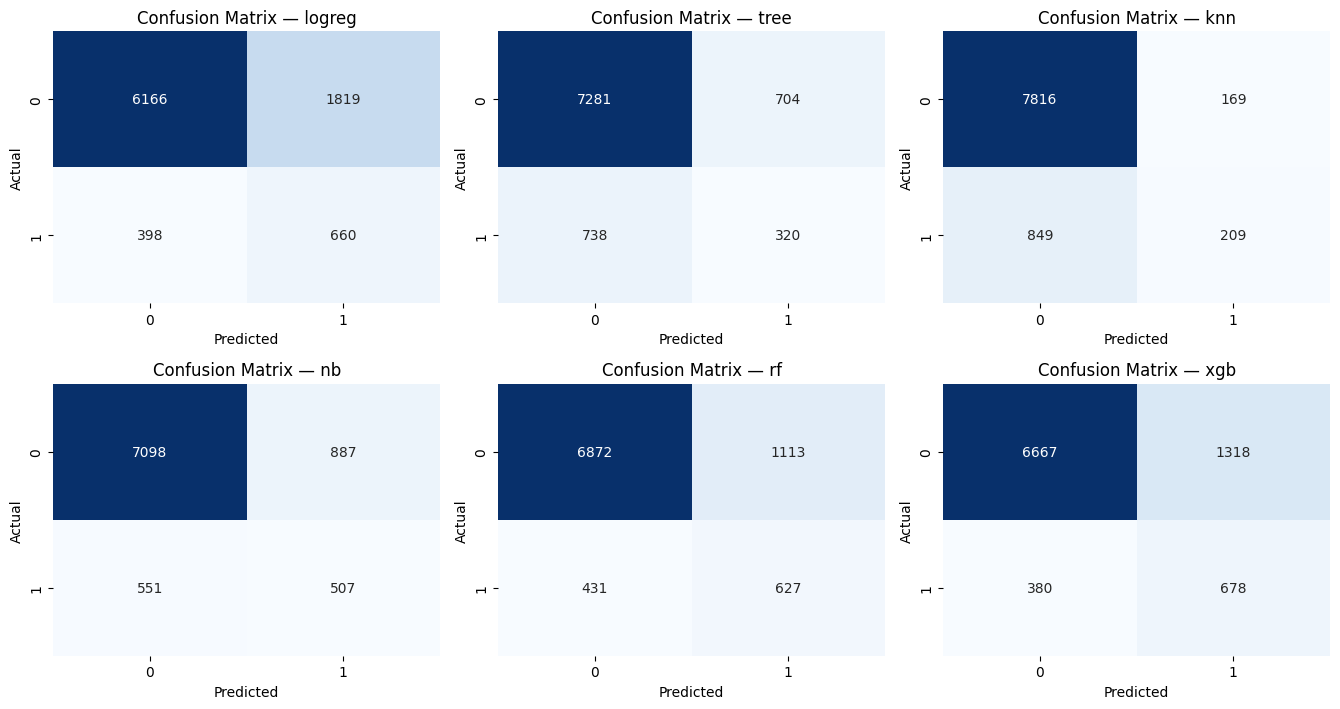

In [15]:
# Visualization: Confusion Matrices

def plot_confusion_matrices_grid(trained, X_test, y_test, max_cols=3, cmap="Blues"):
    names = list(trained.keys())
    m = len(names)
    cols = min(max_cols, m)
    rows = math.ceil(m / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 3.6*rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, name in enumerate(names):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        pipe = trained[name]
        y_pred = pipe.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax)
        ax.set_title(f"Confusion Matrix — {name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # Hide any unused axes
    for j in range(m, rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

# Call it
plot_confusion_matrices_grid(trained, X_test, y_test, max_cols=3)


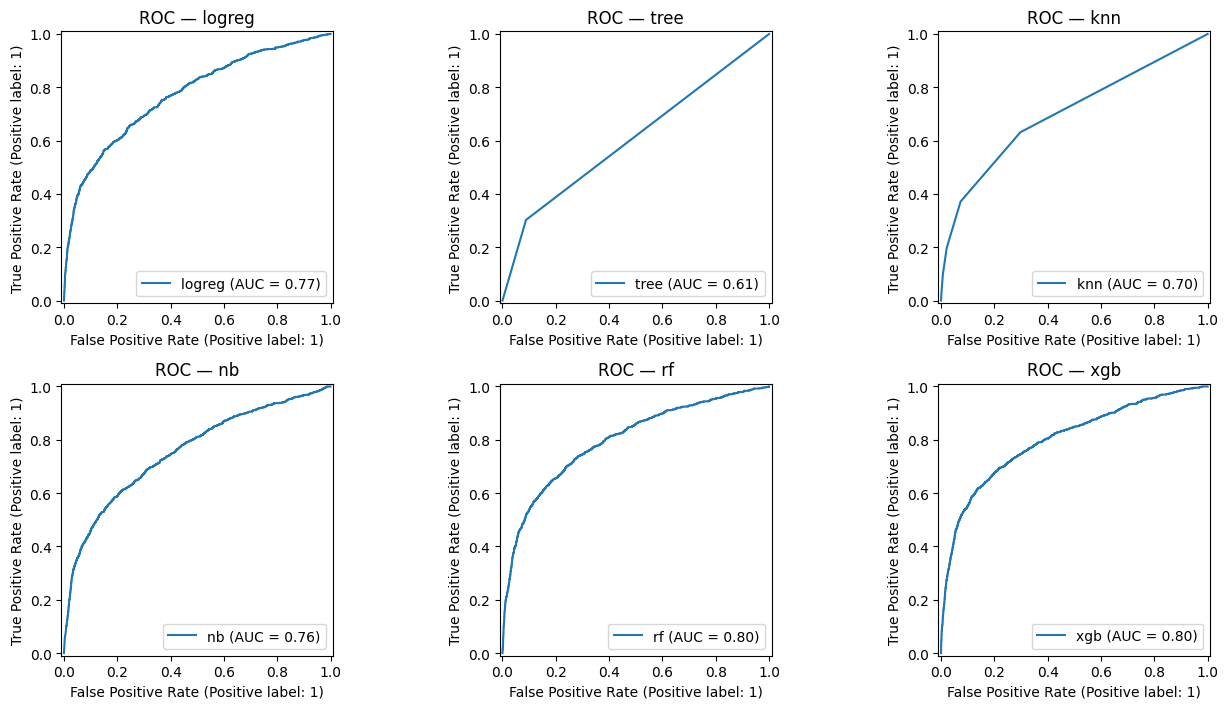

In [16]:
# Visualization: ROC Curves

def plot_roc_curves_grid(trained, X_test, y_test, max_cols=3):
    # Keep only models that expose predict_proba
    names = [n for n, p in trained.items() if hasattr(p, "predict_proba")]
    if not names:
        print("No models support predict_proba — skipping ROC grid.")
        return

    m = len(names)
    cols = min(max_cols, m)
    rows = math.ceil(m / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 3.6 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, name in enumerate(names):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        pipe = trained[name]

        try:
            proba = pipe.predict_proba(X_test)
        except Exception as e:
            ax.axis("off")
            ax.set_title(f"ROC — {name}\n(predict_proba failed)")
            continue

        # Accept either 2D proba (use positive class column) or 1D scores
        if isinstance(proba, np.ndarray) and proba.ndim == 2 and proba.shape[1] >= 2:
            scores = proba[:, 1]
        else:
            scores = proba

        RocCurveDisplay.from_predictions(y_test, scores, name=name, ax=ax)
        ax.set_title(f"ROC — {name}")

    # Hide any unused axes
    for j in range(m, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


# Call it
plot_roc_curves_grid(trained, X_test, y_test, max_cols=3)


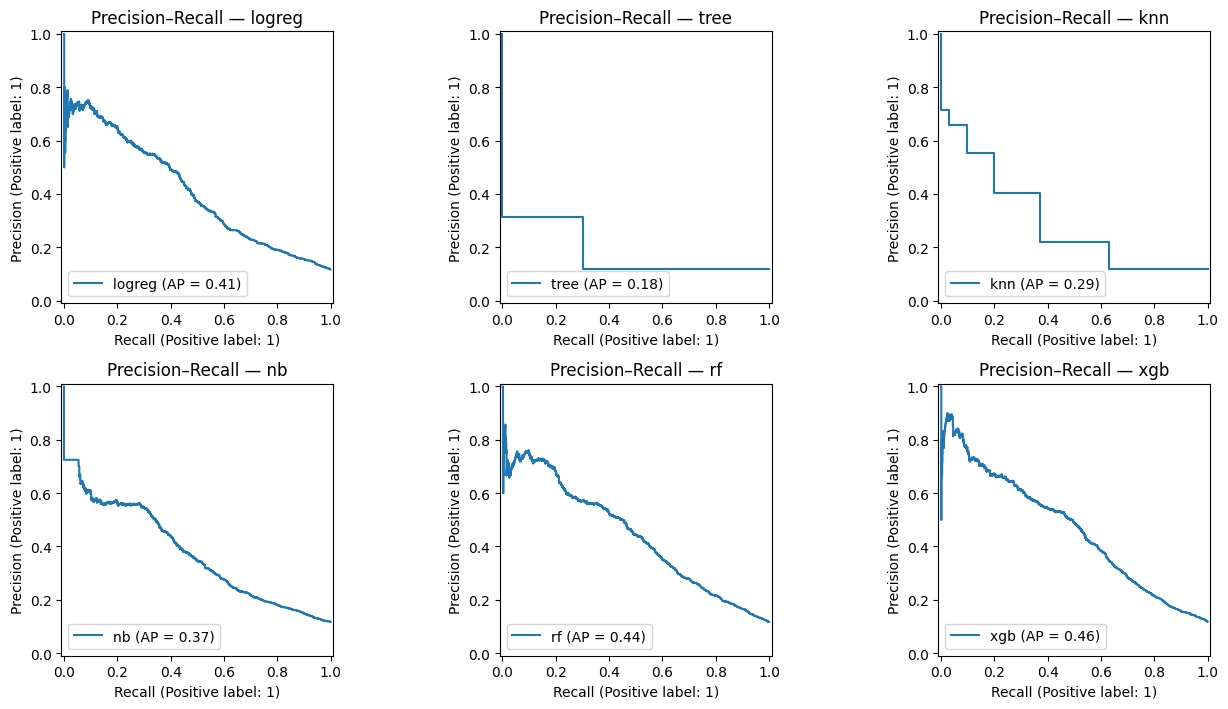

In [17]:
# Visualization: Precision-Recall Curves


def plot_pr_curves_grid(trained, X_test, y_test, max_cols=3):
    # Filter to models that expose predict_proba
    names = [n for n, p in trained.items() if hasattr(p, "predict_proba")]
    if not names:
        print("No models support predict_proba — skipping PR grid.")
        return

    m = len(names)
    cols = min(max_cols, m)
    rows = math.ceil(m / cols)

    # Slightly compact default size; adjust if you want smaller/larger plots
    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 3.6 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, name in enumerate(names):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        pipe = trained[name]

        # Try to obtain probabilities
        try:
            proba = pipe.predict_proba(X_test)
        except Exception:
            ax.axis("off")
            ax.set_title(f"Precision–Recall — {name}\n(predict_proba failed)")
            continue

        # Positive-class scores: use column index 1 if 2D, else use the 1D scores
        if isinstance(proba, np.ndarray) and proba.ndim == 2 and proba.shape[1] >= 2:
            scores = proba[:, 1]
        else:
            scores = proba

        PrecisionRecallDisplay.from_predictions(y_test, scores, name=name, ax=ax)
        ax.set_title(f"Precision–Recall — {name}")

    # Hide unused axes
    for j in range(m, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


# Call it
plot_pr_curves_grid(trained, X_test, y_test, max_cols=3)


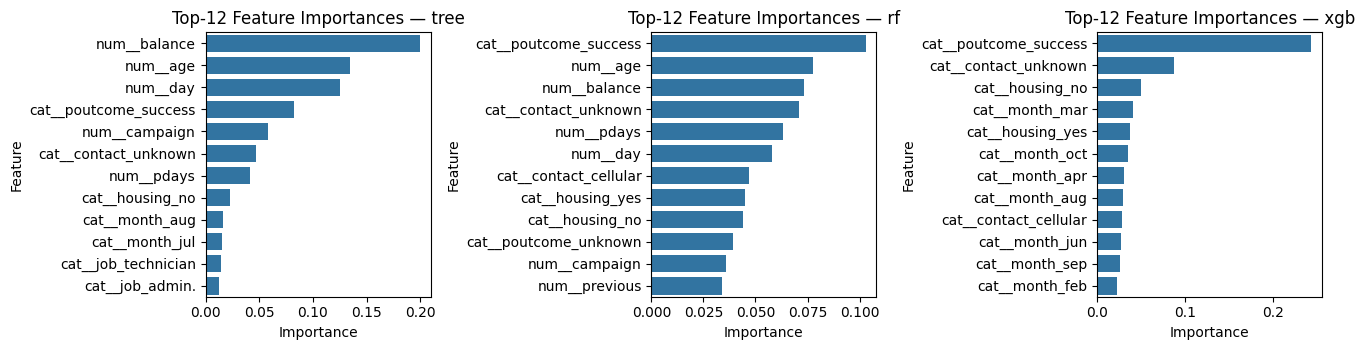

In [18]:
# Visualization: Feature Importances for tree-based models

def plot_feature_importances_grid(trained, X_ref, top_k=12, max_cols=3):
    eligible = []
    for name, pipe in trained.items():
        clf = pipe.named_steps.get("clf", None)
        if clf is not None and hasattr(clf, "feature_importances_"):
            eligible.append(name)

    if not eligible:
        print("No tree-based models with feature_importances_ — skipping.")
        return

    m = len(eligible)
    cols = min(max_cols, m)
    rows = math.ceil(m / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 3.6*rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, name in enumerate(eligible):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        pipe = trained[name]
        clf = pipe.named_steps["clf"]
        importances = clf.feature_importances_

        # get expanded feature names after preprocessing
        feat_names = get_feature_names_from_fitted_preprocessor(fitted_preproc)
        idx = np.argsort(importances)[::-1][:top_k]
        vals = importances[idx]
        labels = [feat_names[j] if j < len(feat_names) else f"f{j}" for j in idx]

        sns.barplot(x=vals, y=labels, orient="h", ax=ax)
        ax.set_title(f"Top-{top_k} Feature Importances — {name}")
        ax.set_xlabel("Importance")
        ax.set_ylabel("Feature")

    # Hide any unused axes
    for j in range(m, rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

# Call it (use train+val or full train features to derive names)
plot_feature_importances_grid(trained, X_train, top_k=12, max_cols=3)


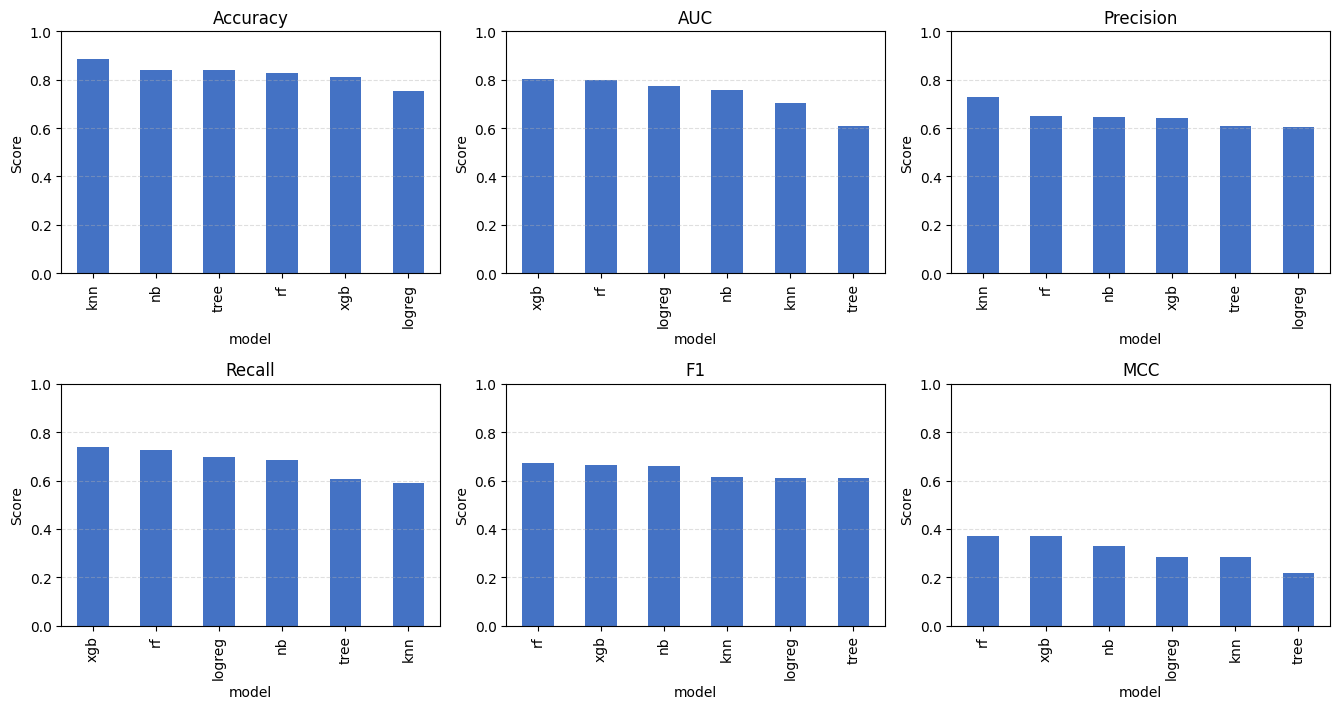

In [19]:
# Visualization: Metrics Bar Charts
def compare_metrics_grid(metrics_df, metrics=("Accuracy", "AUC", "Precision", "Recall", "F1", "MCC")):
    k = len(metrics)
    cols = min(3, k)                 # 3 panels per row
    rows = math.ceil(k / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 3.6*rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, met in enumerate(metrics):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        (metrics_df[met]
         .sort_values(ascending=False)
         .plot(kind="bar", ax=ax, color="#4472C4"))
        ax.set_title(met)
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)  # if all are in [0,1]
        ax.grid(axis="y", linestyle="--", alpha=0.4)

    # Hide any unused axes
    for j in range(k, rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

# Call it
compare_metrics_grid(metrics_df)


In [20]:
def to_markdown_table(df):
    header = "| ML Model | Accuracy | AUC | Precision | Recall | F1 | MCC |"
    sep    = "|---|---:|---:|---:|---:|---:|---:|"
    lines = [header, sep]
    for r in df.itertuples():
        line = f"| {r.Index} | {r.Accuracy:.4f} | {r.AUC:.4f} | {r.Precision:.4f} | {r.Recall:.4f} | {r.F1:.4f} | {r.MCC:.4f} |"
        lines.append(line)
    return "\n".join(lines)

md = to_markdown_table(metrics_df)
print(md)

| ML Model | Accuracy | AUC | Precision | Recall | F1 | MCC |
|---|---:|---:|---:|---:|---:|---:|
| xgb | 0.8122 | 0.8017 | 0.6429 | 0.7379 | 0.6655 | 0.3687 |
| rf | 0.8293 | 0.7983 | 0.6507 | 0.7266 | 0.6736 | 0.3696 |
| logreg | 0.7548 | 0.7722 | 0.6028 | 0.6980 | 0.6104 | 0.2853 |
| nb | 0.8410 | 0.7558 | 0.6458 | 0.6841 | 0.6608 | 0.3277 |
| knn | 0.8874 | 0.7027 | 0.7275 | 0.5882 | 0.6150 | 0.2833 |
| tree | 0.8405 | 0.6071 | 0.6102 | 0.6071 | 0.6086 | 0.2174 |
